# This notebook contains:

* Quick pipeline similar to main.py
* Pareto 3D with blob size etc
* New corridor computation --> fix max number of edges
* KSP with similarity metrics
* KSP with overlap (new formulation)

In [67]:
import os
import pickle
import time
import numpy as np
import json
import matplotlib.pyplot as plt
from types import SimpleNamespace

# utils imports
# from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp, plot_pareto_scatter_3d
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists

#### General configurations

In [ ]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 5  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.WeightedKSP
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "data_dump_" + str(SCALE_PARAM) + ".dat")

with open("../config.json", "r") as infile:
    cfg_dict = json.load(infile)  # Config(SCALE_PARAM)
    cfg = SimpleNamespace(**cfg_dict)
    cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX = compute_pylon_dists(
        cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX, cfg.RASTER, SCALE_PARAM
    )

## Load data

In [ ]:
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data

In [ ]:
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=cfg.ANGLE_WEIGHT
)
graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
# add vertices
graph.add_nodes()

# START PIPELINE
tic = time.time()
corridor = np.ones(instance_corr.shape) * 0.5  # start with all
output_paths = []
plot_surfaces = []
time_infos = []

for (factor, dist) in PIPELINE:
    print("----------- PIPELINE", factor, dist, "---------------")
    graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=factor)
    print("1) set cost rest")
    graph.add_edges()
    print("2) added edges", graph.n_edges)
    print("number of vertices:", graph.n_nodes)

    # weighted sum of all costs
    graph.sum_costs()
    source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
    print("3) summed cost, get source and dest")
    # get actual best path
    path, path_costs, cost_sum = graph.get_shortest_path(source_v, target_v)
    print("4) shortest path")
    # save for inspection
    output_paths.append((path, path_costs))
    plot_surfaces.append(graph.cost_rest[2].copy())  # TODO: mean makes black
    # get several paths --> here: pareto paths
    paths = [path]
    # graph.get_pareto(
    #     np.arange(0, 1.1, 0.1), source_v, target_v, compare=[2, 3]
    # )

    time_infos.append(graph.time_logs.copy())

    if cfg.VERBOSE:
        del graph.time_logs['edge_list_times']
        del graph.time_logs['add_edges_times']
        print(graph.time_logs)

    if dist > 0:
        # PRINT AND SAVE timing test
        time_test_csv(
            ID, cfg.CSV_TIMES, SCALE_PARAM, cfg.GTNX, GRAPH_TYPE, graph,
            path_costs, cost_sum, dist, 0, NOTES
        )
        # do specified numer of dilations
        corridor = get_distance_surface(
            graph.pos2node.shape, paths, mode="dilation", n_dilate=dist
        )
        print("5) compute distance surface")
        # remove the edges of vertices in the corridor (to overwrite)
        graph.remove_vertices(corridor, delete_padding=cfg.PYLON_DIST_MAX)
        print("6) remove edges")

In [ ]:
plot_path_costs(
    instance * instance_corr,
    path,
    path_costs,
    data.layer_classes,
    buffer=2
)

# Improve pareto computation

#### Notes:

We say that an alternative A dominates B if A outscores B regardless of the tradeoff between value and cost — that is, if A is both better and cheaper than B

In [ ]:
import seaborn as sns
sns.set(style="ticks")

def plot_pareto_scatter_matrix(pareto, weights, classes):
    df = pd.DataFrame(pareto)
    sns.pairplot(df)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

def plot_pareto_3d(pareto, weights, classes):
    """
    3D plot of pareto points from 3 cost classes
    Arguments:
        pareto: np array of shape num_paths x 3, with costs for each path
        weights: array or list of shape num_paths x 3, giving the weights that yielded the pareto costs
        classes: list of 3 strings, the compared graphs
    """
    fig = plt.figure(figsize=(10,5))
    ax = Axes3D(fig)
    
    for i in range(len(pareto)):
        x, y, z = tuple(pareto[i])
        col_weights = (np.asarray([weights[i]])+0.4)/1.4
        # print(x,y,z, weights[i])
        ax.scatter(x, y, z, marker='o', s=100, c=col_weights, label=weights[i])

    ax.set_xlabel(classes[0], fontsize=15)
    ax.set_ylabel(classes[1], fontsize=15)
    ax.set_zlabel(classes[2], fontsize=15)
    # manually define legend
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                       Line2D([0], [0], marker='o', color=[0,1,0],lw=0.1, label='only '+classes[1], markersize=10),
                       Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[2], markersize=10)]

    # Create the figure
    ax.legend(handles=legend_elements, loc='upper center', fontsize=17)
    
    plt.show()

In [ ]:
from matplotlib.lines import Line2D

def plot_pareto_scatter_3d(pareto, weights, classes, cost_sum=None):
    """
    3D plot of pareto points from 3 cost classes
    Arguments:
        pareto: np array of shape num_paths x 3, with costs for each path
        weights: array or list of shape num_paths x 3, giving the weights that yielded the pareto costs
        classes: list of 3 strings, the compared graphs
    """
    if cost_sum is not None:
        norm_cost_sums = np.array(cost_sum)
        norm_cost_sums = (norm_cost_sums-np.min(norm_cost_sums))/(np.max(norm_cost_sums)-np.min(norm_cost_sums))
    print(norm_cost_sums)
    
    fig = plt.figure(figsize=(20,5))
    for i in range(3):
        ax = fig.add_subplot(1,3,i+1)
        ind1 = i
        ind2 = (i+1)%3
        for j in range(len(pareto)):
            label=np.argmax(weights[j])
            if cost_sum is not None:
                size = norm_cost_sums[j] * 1000 + 20
            else:
                size = 100
            col_weights = (np.asarray([weights[j]])+0.4)/1.4
            ax.scatter(pareto[j,ind1], pareto[j,ind2], c=col_weights, s=size, label=label)
        plt.xlabel(classes[ind1], fontsize=17)
        plt.ylabel(classes[ind2], fontsize=17)
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                   Line2D([0], [0], marker='o', color=[0,1,0],lw=0.1, label='only '+classes[1], markersize=10),
                     Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[2], markersize=10)]

    # Create the figure
    ax.legend(handles=legend_elements, loc='upper center', fontsize=17)
    plt.savefig("pareto3d.pdf")
    plt.show()
    
def plot_pareto_scatter_2d(pareto, weights, classes, cost_sum=None):
    """
    Scatter to compare two cost classes
    Arguments:
        pareto: np array of shape num_paths x 2, with costs for each path
        weights: array or list of shape num_paths x 2, giving the weights that yielded the pareto costs
        classes: list of 2 strings, the compared graphs
    """
    if cost_sum is not None:
        norm_cost_sums = np.array(cost_sum)
        # normalize
        norm_cost_sums = (norm_cost_sums-np.min(norm_cost_sums))/(np.max(norm_cost_sums)-np.min(norm_cost_sums))
        size = norm_cost_sums * 1000 + 20
    else:
        size= 100
    color = np.array([[w[0], 0, w[1]] for w in weights])
    # scatter pareto curve
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.scatter(pareto[:,0], pareto[:,1], c= color, s=size)# color)
    plt.gray()
    plt.xlabel(classes[0], fontsize=15)
    plt.ylabel(classes[1], fontsize=15)
    # manually create legend
    legend_elements = [Line2D([0], [0],marker='o', color=[1,0,0], markersize=10, lw=0.1, label='only '+classes[0]),
                   Line2D([0], [0], marker='o', color=[0,0,1],lw=0.1, label='only '+classes[1], markersize=10)]
    # Create the figure
    plt.legend(handles=legend_elements, loc='upper center', fontsize=17)
    plt.title("Pareto frontier for " + classes[0] + " vs " + classes[1])
    plt.show()

In [ ]:
def get_pareto(self, vary, source, dest, out_path=None, non_compare_weight=0, compare=[0, 1],plotting=False):
    """
    Arguments:
        vary: how many weights to explore, e.g 3 --> each cost class can have weight 0, 0.5 or 1
        source, dest: as always the source and destination vertex
        out_path: where to save the pareto figure(s)
        compare: indices of cost classes to compare
    Returns:
        paths: All found paths
        pareto: The costs for each combination of weights
    """
    # initialize lists
    pareto = list()
    paths = list()
    cost_sum = list()
    # 
    cost_arrs = [cost.get_array() for cost in self.cost_props]
    # [self.cost_props[comp].get_array() for comp in compare]
    var_weights = np.around(np.linspace(0,1, vary),2)
    
    if len(compare)==2:
        weights = [[v, 1-v] for v in var_weights]
    elif len(compare)==3:
        weights = list()
        for w0 in var_weights:
            for w1 in var_weights[var_weights<=1-w0]:
                weights.append([w0, w1, 1-w0-w1])
    else:
        raise ValueError("argument compare can only have length 2 or 3")
    
    best_sum = []
    w_avail = np.sum(np.asarray(self.cost_weights)[compare])
    print(w_avail)
    for j in range(len(weights)):
        w = self.cost_weights.copy() # np.zeros(len(cost_arrs)) + non_compare_weight
        w[compare] = np.array(weights[j])*w_avail # replace these ones
        # print(w)
        self.weight.a = np.sum([cost_arrs[i] * w[i] for i in range(len(cost_arrs))], axis=0)
        # get shortest path
        path, path_costs, _ = self.get_shortest_path(source, dest)
        pareto.append(np.sum(path_costs, axis=0)[compare])
        print(np.sum(path_costs, axis=0))
        print(w)
        print(np.sum(path_costs))
        print("--------")
        paths.append(path)
        cost_sum.append(np.sum(path_costs))

    # print best weighting
    best_weight = np.argmin(cost_sum)
    w = self.cost_weights.copy()
    w[compare] = np.array(weights[best_weight]) * w_avail
    print("Best weights:", w, "with (unweighted) costs:", np.min(cost_sum))
            
    pareto = np.array(pareto)
    classes = [self.cost_classes[comp] for comp in compare]
    # Plotting
    if plotting:
        if len(compare)==2:
            plot_pareto_scatter_2d(pareto, weights, classes, cost_sum=cost_sum)
        elif len(compare)==3:
            # plot_pareto_3d(pareto, weights, classes)
            plot_pareto_scatter_3d(pareto, weights, classes, cost_sum=cost_sum)
        # TODO: return weights as well
    return paths, weights, cost_sum

In [ ]:
%matplotlib notebook

In [ ]:
pareto_out = get_pareto(
    graph, 10, source_v, target_v, compare=[0, 2, 3], non_compare_weight=0.5, out_path=1, plotting=True
)

In [ ]:
pareto_out[2]

In [ ]:
def plot_pareto_paths(pareto_out, inst, out_path=None):
    """
    Plot k shortest paths on the instance
    Arguments:
        pareto_out: tuple of pareto outputs: (paths, weights, cost sums)
        inst: instance to plot on
    """
    # get relevant information
    paths, weight_colours, cost_sum = pareto_out 

    # plot main image (cost surface)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.swapaxes(inst, 1, 0))
    # iterate over k shortest paths
    for i, path in enumerate(paths):
        path = np.asarray(path)
        col = weight_colours[i]
        if len(col)==2:
            col = [col[0],0,col[1]]
        plt.plot(
            path[:, 0], path[:, 1], label=str(round(cost_sum[i], 2)), c= col, linewidth=3
        )
    # plot and save
    leg = plt.legend(fontsize=15)
    leg.set_title('Weighted costs', prop={'size': 15})
    plt.axis("off")
    if out_path is not None:
        plt.savefig(out_path + "_pareto_paths.pdf")
    else:
        plt.show()

In [ ]:
plot_pareto_paths(pareto_out, graph.instance)

## Plotting

In [ ]:
pareto_paths = get_pareto_3d(
    graph, 3, source_v, target_v, compare=[0, 2, 3], non_compare_weight=0.5, out_path=1
)

In [ ]:
paths = get_pareto(
    graph, 10, source_v, target_v, compare=[0, 2, 3], out_path=1
)

### Interpretaion: 
* possible to optimize for cultural and technical costs simultanously
* if planning and cultural minimized, then technical tends to be high

## Random corridor new method

In [ ]:
from power_planner.utils.utils import normalize

In [ ]:
flipped = (np.unique(corridor_dilate).tolist())
flipped.reverse()
onedim = normalize(np.array(np.unique(corridor_dilate).tolist() + flipped))

In [ ]:
gauss = lambda x: np.exp(-(x-1)**2/(0.5))

In [ ]:
# plt.plot(np.log(onedim))
plt.plot(np.sqrt(onedim), label="sqrt")
plt.plot(onedim**2, label="squared")
plt.plot(normalize(onedim), label="lin")
plt.plot(gauss(onedim), label="gauss")
plt.legend()
plt.show()

### Observations:

corr so small because negative values! --> half of the corridor just vanishes
--> would need to take values close to 0.5 instead -> still using half of the points

and actually not even 0.5, but such that cutoff corridor is at 0.5!

In [ ]:
arr1 = np.random.rand(1000)*0.2

In [ ]:
np.mean(arr1)

In [ ]:
arr2 = np.random.rand(1000)

In [ ]:
np.sum((arr1>arr2).astype(bool))/1000

In [ ]:
# need to scale mean of corridor!

### New method (not cutting off corridor)

In [ ]:
corridor_dilate = get_distance_surface(
            instance_corr.shape, [path], mode="dilation", n_dilate=30
        )
factor = 0.3

In [ ]:
corridor = corridor_dilate.copy()

In [ ]:
mode = "gauss"
if mode == "gauss":
    gauss = lambda x: np.exp(-(x - 1)**2 / (4))
    corridor = normalize(gauss(normalize(corridor)))
elif mode == "same":
    corridor = normalize(corridor)
elif mode == "squared":
    corridor = normalize(corridor)**2
elif mode == "squareroot":
    corridor = np.sqrt(normalize(corridor))
else:
    raise NotImplementedError("mode must be gauss, squared...")

In [ ]:
plt.imshow(corridor)
plt.colorbar()
plt.show()

In [ ]:
mean_val_now = np.mean(corridor[corridor>0])
n_entris = len(corridor_dilate[corridor_dilate>0])
print("entries orig", len(corridor_dilate[corridor_dilate>0]), "entries now", len(corridor[corridor>0]))

In [ ]:
if mean_val_now > 1-factor:
    scale_factor = (1-factor)/mean_val_now
    print("scale_factor", scale_factor)
    corridor = corridor*scale_factor
else:
    scale_factor = factor/(1-mean_val_now)
    print("scale_factor", scale_factor)
    larger_zero = (corridor>0).astype(int)
    corridor = 1-scale_factor + corridor*scale_factor
    # have to reset to 0
    corridor = corridor*larger_zero

In [ ]:
print(np.mean(corridor[corridor>0]), "should be", (1-factor))

In [ ]:
arr = np.random.rand(*corridor.shape)
corr_thresh = (corridor>arr).astype(int)

In [ ]:
# plt.figure(figsize=(20,10))
plt.imshow(corr_thresh)
plt.show()

In [ ]:
arr = np.random.rand(*corridor.shape)
corr_thresh = (corridor>arr).astype(int)
leftover=len(corr_thresh[corr_thresh>0])
print("entries leftover", leftover)

In [ ]:
print("RATIO DEL",(n_entris-leftover)/ n_entris,"should be", factor)

In [ ]:
n_entris

In [ ]:
15000000 #edges actually

In [ ]:
250 * 550 * 150

In [ ]:
# get entries of hard_constraints
# n_nodes_hard = len(self.hard_constraints[self.hard_constraints > 0])

n_edges_desired = 5000000
n_nodes_hard = len(corridor[corridor > 0])
# edges_approx is the number of edges we would get if we take the whole corridor
n_edges_approx = len(self.shifts) * n_nodes_hard
print("desired", n_edges_desired, "n nodes in corridor", n_nodes_hard, "approximate_edges", n_edges_approx)

# ratio of edges to delete x
ratio_keep = (n_edges_desired/n_edges_approx)
# in the beginning: second part is 1, so simply taking the edge ratio
# later: second part is smaller, so deleting less edges
# min because might happen that corridor has less edges anyways then the desired maximum
factor = min([1-ratio_keep, 1])
print(ratio_keep, factor)

In [ ]:
np.random.permutation(30)

# Improve ksp - similarity metrics

In [ ]:
from graph_tool.all import shortest_distance

In [ ]:
def similarity(s1, s2, mode="IoU"):
    path_inter = len(s1.intersection(s2))
    if mode=="IoU":
        return path_inter/len(s1.union(s2))
    elif mode=="sim2paper":
        return path_inter/(2*len(s1)) + path_inter/(2*len(s2))
    elif mode=="sim3paper":
        return np.sqrt(path_inter**2 / (len(s1)*len(s2)))
    elif mode=="max_norm_sim":
        return path_inter/(max([len(s1), len(s2)]))
    elif mode=="min_norm_sim":
        return path_inter/(min([len(s1), len(s2)]))
    else:
        raise NotImplementedError("mode wrong, not implemented yet")

def k_shortest_paths(self, source, dest, k, overlap=0.5, mode="myset"):
    tic = time.time()
    # initialize list of paths
    sp_set = set(self.best_path)
    best_paths = [self.best_path]
    best_path_sets = [set(self.best_path)]
    # get list of vertices = unique values in pos2node except -1
    vertices = np.unique(self.pos2node)[1:]
    v_dists = [self.dist_map_ab[v] + self.dist_map_ba[v] for v in vertices]
    # sort paths
    v_shortest = np.argsort(v_dists)
    # iterate over vertices starting from shortest paths
    # times_getpath = []
    for j, v_ind in enumerate(v_shortest):
        v = vertices[v_ind]
        # TODO: for runtime scan only every xth one (anyways diverse)
        if v not in sp_set:
            # do not scan unreachable vertices
            if int(self.pred_map_ab[v]
                   ) == int(v) or int(self.pred_map_ba[v]) == int(v):
                continue
            # tic1 = time.time()
            try:
                path_ac = self.get_sp_from_preds(
                    self.pred_map_ab, v, source
                )
                path_cb = self.get_sp_from_preds(self.pred_map_ba, v, dest)
            except RuntimeWarning:
                print("while loop not terminating")
                continue
            # times_getpath.append(time.time() - tic1)
            path_ac.reverse()
            # concatenate - leave 1 away because otherwise twice
            vertices_path = path_ac + path_cb[1:]
            
            # similar = similarity(vertices_path, best_paths, sp_set)
            if mode!="myset":
                sofar = np.array([similarity(sp, set(vertices_path), mode) for sp in best_path_sets])
                if np.all(sofar<overlap):
                    best_paths.append(vertices_path)
                    best_path_sets.append(set(vertices_path))
            # mode myset --> my version: set of all paths together 
            else:
                already = np.array([u in sp_set for u in vertices_path])
                if np.sum(already) < len(already) * overlap:
                    best_paths.append(vertices_path)
                    sp_set.update(vertices_path)
                # print("added path, already scanned", j)
        # stop if k paths are sampled
        if len(best_paths) >= k:
            break

    self.time_logs["ksp"] = round(time.time() - tic, 3)
    return [self.transform_path(p) for p in best_paths]

In [ ]:
graph.get_shortest_path_tree(source_v, target_v)

In [ ]:
ksp = k_shortest_paths(graph, source_v, target_v, 10, overlap=0.5, mode="sim3paper")

In [ ]:
print([k[2] for k in ksp])

### Compare all similarity metrics with threshold 0.5

In [ ]:
for mode in ["myset", "IoU","sim2paper", "sim3paper", "max_norm_sim", "min_norm_sim"]:
    ksp = k_shortest_paths(graph, source_v, target_v, 10, overlap=0.5, mode=mode)
    print("---------------   MODE: ", mode, "-------------------")
    plot_k_sp(ksp, graph.instance, out_path=None)

### Compare all similarity metrics with threshold 0.3

In [ ]:
for mode in ["myset", "IoU","sim2paper", "sim3paper", "max_norm_sim", "min_norm_sim"]:
    ksp = k_shortest_paths(graph, source_v, target_v, 10, overlap=0.3, mode=mode)
    print("---------------   MODE: ", mode, "-------------------")
    plot_k_sp(ksp, graph.instance, out_path=None)

## Observations:

* very similar results in general
* IoU requires lower threshold than others (leading to less diverse paths)
* min and max norm do differ slightly in this example
* my set does only differ from others in this example by exchanging two paths (-->80% paths are same)

# Rotate array

In [ ]:
import numpy as np
import scipy.sparse
import math


N = 10
space = np.zeros((N, N), dtype=np.int8)
space[3:7, 3:7].fill(1)
print(space)
print(np.sum(space))

space_coo = scipy.sparse.coo_matrix(space)
Coords = np.array(space_coo.nonzero()) - 3

theta = 30 * 3.1416 / 180

R = np.array([[math.cos(theta), math.sin(theta)], [-math.sin(theta), math.cos(theta)]])
space2_coords = R.dot(Coords)
space2_coords = np.round(space2_coords)
space2_coords += 3
space2_sparse = scipy.sparse.coo_matrix(([1] * space2_coords.shape[1], (space2_coords[0], space2_coords[1])), shape=(N, N))
space2 = space2_sparse.todense()
print(space2)
print(np.sum(space2))

# Pareto for implicit

In [2]:
import pandas as pd

### DE instance

In [71]:
base_path = "../../outputs/de_new_data/pareto/"
compare = ["angle", "resistance", "edge_costs"]

plot = True
minimal_weights = np.array([1, 2])
maximal_weights = np.array([9, 30])

pareto, weight_list, cost_sum, paths = [], [], [], []
for f in os.listdir(base_path):
    if f.endswith("csv"):
        # get current weights
        weights = f.split("_")[-3:-1] # + ["r1"] # plus resistance weight is always 1
        print(weights)
        weights = (np.array([int(w[1:]) for w in weights]) - minimal_weights) / (maximal_weights - minimal_weights)
        # NEW METHOD:
        weights = list(weights)
        # OLD METHOD: 
        # weights = list(weights/max([np.sum(weights), 0.01]))
        weights.insert(1, np.max([1-np.sum(weights), 0]))
        weights = weights/np.sum(weights)
        print(weights)
        weight_list.append(np.array(weights))
        # get costs
        path_csv = pd.read_csv(os.path.join(base_path, f))
        path_costs = np.asarray(path_csv[compare])
        pareto.append(np.sum(path_costs, axis=0))
        cost_sum.append(np.sum(path_costs[:,1]))
        
        # get paths
        paths.append(np.asarray(path_csv[["X_raw", "Y_raw"]]))
        
pareto = np.asarray(pareto)
weight_list = np.asarray(weight_list)    

['a9', 'e5']
[0.90322581 0.         0.09677419]
['a1', 'e8']
[0.         0.78571429 0.21428571]
['a3', 'e5']
[0.25       0.64285714 0.10714286]
['a1', 'e15']
[0.         0.53571429 0.46428571]
['a6', 'e30']
[0.38461538 0.         0.61538462]
['a9', 'e20']
[0.60869565 0.         0.39130435]
['a1', 'e30']
[0. 0. 1.]
['a3', 'e20']
[0.25       0.10714286 0.64285714]
['a3', 'e2']
[0.25 0.75 0.  ]
['a6', 'e8']
[0.625      0.16071429 0.21428571]
['a9', 'e2']
[1. 0. 0.]
['a6', 'e15']
[0.57377049 0.         0.42622951]
['a3', 'e15']
[0.25       0.28571429 0.46428571]
['a1', 'e5']
[0.         0.89285714 0.10714286]
['a9', 'e8']
[0.82352941 0.         0.17647059]
['a6', 'e2']
[0.625 0.375 0.   ]
['a9', 'e30']
[0.5 0.  0.5]
['a3', 'e8']
[0.25       0.53571429 0.21428571]
['a6', 'e20']
[0.49295775 0.         0.50704225]
['a6', 'e5']
[0.625      0.26785714 0.10714286]
['a3', 'e30']
[0.2 0.  0.8]
['a1', 'e2']
[0. 1. 0.]
['a1', 'e20']
[0.         0.35714286 0.64285714]
['a9', 'e15']
[0.68292683 0.    

### CH instance

In [8]:
base_path = "../../outputs/pareto_ch/"
compare = ["Bau/Unterhalt", "Raumplanung", "Umwelt-/Biotopschutz"]

plot = True
minimal_weights = np.array([1, 2])
maximal_weights = np.array([9, 30])

pareto, weight_list, cost_sum, paths = [], [], [], []
for f in os.listdir(base_path):
    if f.endswith("csv"):
        # get current weights
        print(f)
        weights = f.split("_")[-4:-1] # + ["r1"] # plus resistance weight is always 1
        weights = [int(w[1:]) for w in weights]
        print(weights)
        weights = weights/np.sum(weights)
        print(weights)
        weight_list.append(np.array(weights))
        # get costs
        path_csv = pd.read_csv(os.path.join(base_path, f))
        path_costs = np.asarray(path_csv[compare])
        pareto.append(np.sum(path_costs, axis=0))
        cost_sum.append(np.sum(path_costs))
        
        # get paths
        paths.append(np.asarray(path_csv[["X_raw", "Y_raw"]]))
        
pareto = np.asarray(pareto)    
weight_list = np.asarray(weight_list)    

power_analysis_angle_chsensitivity_b2_p4_u4_0.csv
[2, 4, 4]
[0.2 0.4 0.4]
Index(['X', 'Y', 'X_raw', 'Y_raw', 'angle', 'Bau/Unterhalt', 'Raumplanung',
       'Umwelt-/Biotopschutz', 'edge_costs', 'heigths'],
      dtype='object')
power_analysis_angle_chsensitivity_b8_p2_u0_0.csv
[8, 2, 0]
[0.8 0.2 0. ]
Index(['X', 'Y', 'X_raw', 'Y_raw', 'angle', 'Bau/Unterhalt', 'Raumplanung',
       'Umwelt-/Biotopschutz', 'edge_costs', 'heigths'],
      dtype='object')
power_analysis_angle_chsensitivity_b2_p0_u8_0.csv
[2, 0, 8]
[0.2 0.  0.8]
Index(['X', 'Y', 'X_raw', 'Y_raw', 'angle', 'Bau/Unterhalt', 'Raumplanung',
       'Umwelt-/Biotopschutz', 'edge_costs', 'heigths'],
      dtype='object')
power_analysis_angle_chsensitivity_b4_p2_u4_0.csv
[4, 2, 4]
[0.4 0.2 0.4]
Index(['X', 'Y', 'X_raw', 'Y_raw', 'angle', 'Bau/Unterhalt', 'Raumplanung',
       'Umwelt-/Biotopschutz', 'edge_costs', 'heigths'],
      dtype='object')
power_analysis_angle_chsensitivity_b6_p0_u4_0.csv
[6, 0, 4]
[0.6 0.  0.4]
Index(['X'

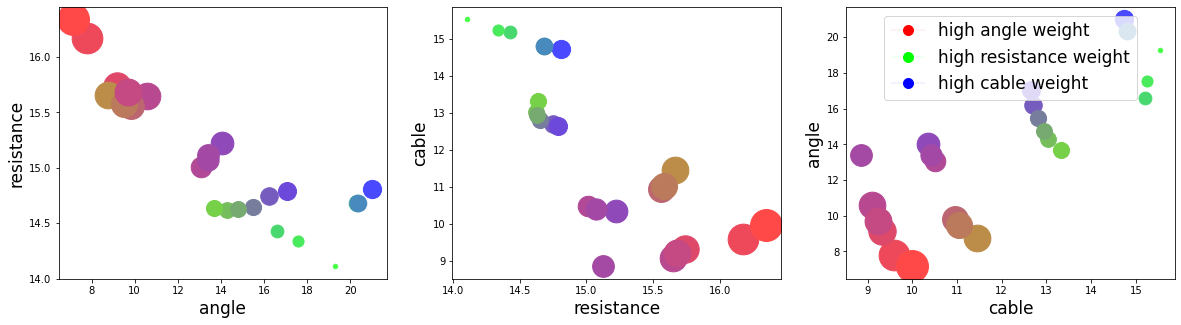

In [73]:
# compare= ["technical", "planning", "environment"]
compare = ["angle", "resistance", "cable"]
if plot:
    if len(compare) == 2:
        plot_pareto_scatter_2d(
            pareto,
            weight_list,
            classes,
            cost_sum=cost_sum,
            out_path=out_path
        )
    elif len(compare) == 3:
        # plot_pareto_3d(pareto, weights, classes)
        plot_pareto_scatter_3d(
            pareto,
            weight_list,
            compare,
            cost_sum=cost_sum,
            out_path="../../figure/pareto_de"
        )

In [62]:
from matplotlib.lines import Line2D
def plot_pareto_scatter_3d(
    pareto, weights, classes, cost_sum=None, out_path=None
):
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker='o',
            color=[1, 0, 0],
            markersize=17,
            lw=0,
            label='high ' + classes[0] + ' weight',
        ),
        Line2D(
            [0], [0],
            marker='o',
            color=[0, 1, 0],
            lw=0,
            label='high ' + classes[1] + ' weight',
            markersize=17
        ),
        Line2D(
            [0], [0],
            marker='o',
            color=[0, 0, 1],
            lw=0,
            label='high ' + classes[2] + ' weight',
            markersize=17
        )
    ]


    """
    3D plot of pareto points from 3 cost classes
    Arguments:
        pareto: np array of shape num_paths x 3, with costs for each path
        weights: array or list of shape num_paths x 3, giving the weights that
                yielded the pareto costs
        classes: list of 3 strings, the compared graphs
    """
    if cost_sum is not None:
        norm_cost_sums = np.array(cost_sum)
        # min max normalization
        norm_cost_sums = (norm_cost_sums - np.min(norm_cost_sums)) / (
            np.max(norm_cost_sums) - np.min(norm_cost_sums)
        )
    # print(norm_cost_sums)
    size = 100

    fig = plt.figure(figsize=(20, 5))
    for i in range(3):
        ax = fig.add_subplot(1, 3, i + 1)
        ind1 = i
        ind2 = (i + 1) % 3
        for j in range(len(pareto)):
            label = np.argmax(weights[j])
            if cost_sum is not None:
                size = norm_cost_sums[j] * 1000 + 20
            col_weights = (np.asarray([weights[j]]) + 0.4) / 1.4
            ax.scatter(
                pareto[j, ind1],
                pareto[j, ind2],
                c=col_weights,
                s=size,
                label=label
            )
            if i==1:
                #  bbox_to_anchor=[1.3,1],
                # Create the figure
                legend=ax.legend(handles=legend_elements, loc='upper right', fontsize=15,frameon=True,framealpha=1, labelspacing=.5)
                legend.get_frame().set_linewidth(4)
    
        plt.xlabel(classes[ind1], fontsize=17)
        plt.ylabel(classes[ind2], fontsize=17)
    # plt.tight_layout()
    
    if out_path is not None:
        plt.savefig(out_path + ".pdf", pad_inches=0)
    else:
        plt.show()

### Plot paths

In [ ]:
from power_planner.plotting import plot_pareto_paths

In [ ]:
plot_pareto_paths((paths, weight_list, cost_sum), instance2[0]) # np.moveaxis(instance2, 0,-1))